In [1]:
from collections import defaultdict
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import functools
from IPython.display import display, Markdown
import math
import os
from pprint import pprint
import warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import dask.dataframe as dd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
import scipy as sci
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import sympy as sym

In [2]:
# Ramdam
np.random.seed(2019)
os.environ["PYTHONHASHSEED"] = "2019"
# Matplotlib
plt.style.use("seaborn-ticks")
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 11.0
plt.rcParams["figure.figsize"] = (9, 6)
# Pandas
pd.set_option("display.max_colwidth", 1000)

In [3]:
def line_plot(df, title, xlabel=None, ylabel="Cases",
              h=None, v=None, xlim=(None, None), ylim=(0, None),
              math_scale=True, x_logscale=False, y_logscale=False, y_integer=False,
              show_legend=True, bbox_to_anchor=(1.02, 0),  bbox_loc="lower left"):
    """
    Show chlonological change of the data.
    """
    ax = df.plot()
    # Scale
    if math_scale:
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style="sci",  axis="y",scilimits=(0, 0))
    if x_logscale:
        ax.set_xscale("log")
        if xlim[0] == 0:
            xlim = (None, None)
    if y_logscale:
        ax.set_yscale("log")
        if ylim[0] == 0:
            ylim = (None, None)
    if y_integer:
        fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
        fmt.set_scientific(False)
        ax.yaxis.set_major_formatter(fmt)
    # Set metadata of figure
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    if show_legend:
        ax.legend(bbox_to_anchor=bbox_to_anchor, loc=bbox_loc, borderaxespad=0)
    else:
        ax.legend().set_visible(False)
    if h is not None:
        ax.axhline(y=h, color="black", linestyle=":")
    if v is not None:
        if not isinstance(v, list):
            v = [v]
        for value in v:
            ax.axvline(x=value, color="black", linestyle=":")
    plt.tight_layout()
    plt.show()

In [4]:
def simulation(model, initials, step_n, **params):
    """
    Solve ODE of the model.
    @model <ModelBase>: the model
    @initials <tuple[float]>: the initial values
    @step_n <int>: the number of steps
    @params: the paramerters of the model
    """
    tstart, dt, tend = 0, 1, step_n
    sol = solve_ivp(
        fun=model(**params),
        t_span=[tstart, tend],
        y0=np.array(initials, dtype=np.float64),
        t_eval=np.arange(tstart, tend + dt, dt),
        dense_output=False
    )
    t_df = pd.Series(data=sol["t"], name="t")
    y_df = pd.DataFrame(data=sol["y"].T.copy(), columns=model.VARIABLES)
    sim_df = pd.concat([t_df, y_df], axis=1)
    return sim_df

In [5]:
class ModelBase(object):
    NAME = "Model"
    VARIABLES = ["x"]
    PRIORITIES = np.array([1])
    QUANTILE_RANGE = [0.3, 0.7]
    MONOTONIC = ["x"]

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        """
        Define parameters without tau. This function should be overwritten.
        @train_df_divided <pd.DataFrame>:
            - column: t and non-dimensional variables
        @q_range <list[float, float]>: quantile rage of the parameters calculated by the data
        @return <dict[name]=(min, max):
            @min <float>: min value
            @max <float>: max value
        """
        param_dict = dict()
        return param_dict

    @staticmethod
    def calc_variables(df):
        """
        Calculate the variables of the model.
        This function should be overwritten.
        @df <pd.DataFrame>
        @return <pd.DataFrame>
        """
        return df

    @staticmethod
    def calc_variables_reverse(df):
        """
        Calculate measurable variables using the variables of the model.
        This function should be overwritten.
        @df <pd.DataFrame>
        @return <pd.DataFrame>
        """
        return df

    @classmethod
    def create_dataset(cls, ncov_df, total_population, **kwargs):
        """
        Create dataset with the model-specific varibles.
        The variables will be divided by total population.
        The column names (not include T) will be lower letters.
        **kwargs: See the function named create_target_df()
        @return <tuple(objects)>:
            - start_date <pd.Timestamp>
            - initials <tuple(float)>: the initial values
            - Tend <int>: the last value of T
            - df <pd.DataFrame>: the dataset
        """
        start_date, target_df = create_target_df(ncov_df, total_population, **kwargs)
        df = cls.calc_variables(target_df).set_index("T") / total_population
        df.columns = [n.lower() for n in df.columns]
        initials = df.iloc[0, :].values
        df = df.reset_index()
        Tend = df.iloc[-1, 0]
        return (start_date, initials, Tend, df)

    def calc_r0(self):
        """
        Calculate R0. This function should be overwritten.
        """
        return None

    def calc_days_dict(self, tau):
        """
        Calculate 1/beta [day] etc.
        This function should be overwritten.
        @param tau <int>: tau value [hour]
        """
        return dict()

In [6]:
class SIRD(ModelBase):
    NAME = "SIR-D"
    VARIABLES = ["x", "y", "z", "w"]
    PRIORITIES = np.array([1, 10, 10, 2])
    MONOTONIC = ["z", "w"]

    def __init__(self, kappa, rho, sigma):
        super().__init__()
        self.kappa = kappa
        self.rho = rho
        self.sigma = sigma

    def __call__(self, t, X):
        # x, y, z, w = [X[i] for i in range(len(self.VARIABLES))]
        # dxdt = - self.rho * x * y
        # dydt = self.rho * x * y - (self.sigma + self.kappa) * y
        # dzdt = self.sigma * y
        # dwdt = self.kappa * y
        dxdt = - self.rho * X[0] * X[1]
        dydt = self.rho * X[0] * X[1] - (self.sigma + self.kappa) * X[1]
        dzdt = self.sigma * X[1]
        dwdt = self.kappa * X[1]
        return np.array([dxdt, dydt, dzdt, dwdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        if train_df_divided is not None:
            df = train_df_divided.copy()
            # kappa = (dw/dt) / y
            kappa_series = df["w"].diff() / df["t"].diff() / df["y"]
            param_dict["kappa"] = kappa_series.quantile(q_range)
            # rho = - (dx/dt) / x / y
            rho_series = 0 - df["x"].diff() / df["t"].diff() / df["x"] / df["y"]
            param_dict["rho"] = rho_series.quantile(q_range)
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = sigma_series.quantile(q_range)
            return param_dict
        param_dict["kappa"] = (0, 1)
        param_dict["rho"] = (0, 1)
        param_dict["sigma"] = (0, 1)
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X"] = df["Susceptible"]
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"]
        df["W"] = df["Fatal"]
        return df.loc[:, ["T", "X", "Y", "Z", "W"]]

    @staticmethod
    def calc_variables_reverse(df):
        df["Susceptible"] = df["X"]
        df["Infected"] = df["Y"]
        df["Recovered"] = df["Z"]
        df["Deaths"] = df["W"]
        return df

    def calc_r0(self):
        try:
            r0 = self.rho / (self.sigma + self.kappa)
        except ZeroDivisionError:
            return np.nan
        return round(r0, 2)


    def calc_days_dict(self, tau):
        _dict = dict()
        if self.kappa == 0:
            _dict["1/alpha2 [day]"] = 0
        else:
            _dict["1/alpha2 [day]"] = int(tau / 24 / 60 / self.kappa)
        _dict["1/beta [day]"] = int(tau / 24 / 60 / self.rho)
        if self.sigma == 0:
            _dict["1/gamma [day]"] = 0
        else:
            _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

## SIR-D model
Because we are measuring the number of fatal cases and recovered cases separately, we can use two variables ("Recovered" and "Deaths") instead of "Recovered + Deaths" in the mathematical model.

### What is SIR-D model?
* S: Susceptible
* I: Infected
* R: Recovered
* D: Deaths

Model:  
\begin{align*}
\mathrm{S} \overset{\beta  I}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}  \\
& \mathrm{I} \overset{\alpha}{\longrightarrow} \mathrm{D}  \\
\end{align*}

$\alpha$: Mortality rate [1/min]  
$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery rate [1/min]  

Ordinary Differential Equation (ODE):
\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I  \\
& \frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - (\gamma + \alpha) I  \\
& \frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I  \\
& \frac{\mathrm{d}D}{\mathrm{d}T}= \alpha I  \\
\end{align*}

Where $N=S+I+R+D$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR-D model
Set $(S, I, R, D) = N \times (x, y, z, w)$ and $(T, \alpha, \beta, \gamma) = (\tau t, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  
This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \kappa y  \\
\end{align*}

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
\begin{align*}
& 0 \leq (x, y, z, w, \kappa, \rho, \sigma) \leq 1  \\
\end{align*}
\begin{align*}
& 1\leq \tau \leq 1440  \\
\end{align*}

Reproduction number can be defined as  
\begin{align*}
R_0 = \rho (\sigma + \kappa)^{-1} = \beta (\gamma + \alpha)^{-1}
\end{align*}

Estimated Mean Values of $R_0$:  
$R_0$ ("R naught") means "the average number of secondary infections caused by an infected host" ([Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)).  
(Secondary data: [Van den Driessche, P., & Watmough, J. (2002).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002118))  
2.06: Zika in South America, 2015-2016  
1.51: Ebola in Guinea, 2014  
1.33: H1N1 influenza in South Africa, 2009  
3.5 : SARS in 2002-2003  
1.68: H2N2 influenza in US, 1957  
3.8 : Fall wave of 1918 Spanish influenza in Genova  
1.5 : Spring wave of 1918 Spanish influenza in Genova  

In [7]:
edades = pd.read_csv('piramide_2019.csv') # https://www.populationpyramid.net/es/espa%C3%B1a/2019/
poblacion_total = edades['Hombres'].sum() + edades['Mujeres'].sum()
edades[:3]

,Edad,Hombres,Mujeres,Tasa mortalidad
0,0-4,1038501,977680,0.05
1,5-9,1198575,1125661,0.05
2,10-14,1276540,1195708,0.20


# Apertura total:
___

For example, set $R_0 = 2.5, \kappa=0.005, \rho=0.2$ and initial values $(x_{(0)}, y_{(0)}, z_{(0)}, w_{(0)}) = (0.999, 0.001, 0, 0)$.

In [8]:
r0, kappa, rho = (2.5, 0.005, 0.2) #(numero reproductivo, tasa mortalidad * tau, tasa efectiva contagio * tau)
sigma = rho / r0 - kappa
initials = (0.999, 0.001, 0, 0) # (susceptibles, infectados, recuperados, fallecidos)
display(Markdown(rf"$\kappa = {kappa},\ \rho = {rho},\ \sigma = {sigma}$."))

$\kappa = 0.005,\ \rho = 0.2,\ \sigma = 0.075$.

Suponemos que el día inicial es el 5 de Mayo de 2020. $\tau=1440$ minutos y abrimos al total de la población $N=1,000,000$.

In [9]:
tau = 1440
dia_inicial = datetime.datetime(2020, 5, 5)
poblacion = poblacion_total

In [10]:
%%time
df = simulation(SIRD, initials, step_n=200, kappa=kappa, rho=rho, sigma=sigma)
df.tail()

CPU times: user 9.77 ms, sys: 677 µs, total: 10.4 ms
Wall time: 58.4 ms


,t,x,y,z,w
196,196,0.106463,0.000205,0.837499,0.055833
197,197,0.106459,0.000193,0.837514,0.055834
198,198,0.106455,0.000182,0.837528,0.055835
199,199,0.106451,0.000172,0.837541,0.055836
200,200,0.106448,0.000162,0.837553,0.055837


In [11]:
ori_df = pd.DataFrame(
    {
        "Date": (df["t"] * tau).apply(lambda x: timedelta(minutes=x)) + dia_inicial,
        "Group": "Stopping",
        "País": "España",
        "Province": "-",
        "Susceptible": 0,
        "Confirmed": 0,
        "Infected": (df["y"] * poblacion).astype(np.int64)
    }
)
ori_df["Recovered"] = (df["z"] * poblacion).astype(np.int64)
ori_df["Deaths"] = (df["w"] * poblacion).astype(np.int64)
ori_df["Confirmed"] = ori_df[["Infected", "Recovered", "Deaths"]].sum(axis=1)
ori_df["Susceptible"] = poblacion - ori_df["Confirmed"]
ori_df.tail()

,Date,Group,País,Province,Susceptible,Confirmed,Infected,Recovered,Deaths
196,2020-11-17,Stopping,España,-,4975759,41761023,9567,39141990,2609466
197,2020-11-18,Stopping,España,-,4975562,41761220,9021,39142687,2609512
198,2020-11-19,Stopping,España,-,4975375,41761407,8507,39143344,2609556
199,2020-11-20,Stopping,España,-,4975199,41761583,8022,39143964,2609597
200,2020-11-21,Stopping,España,-,4975034,41761748,7564,39144548,2609636


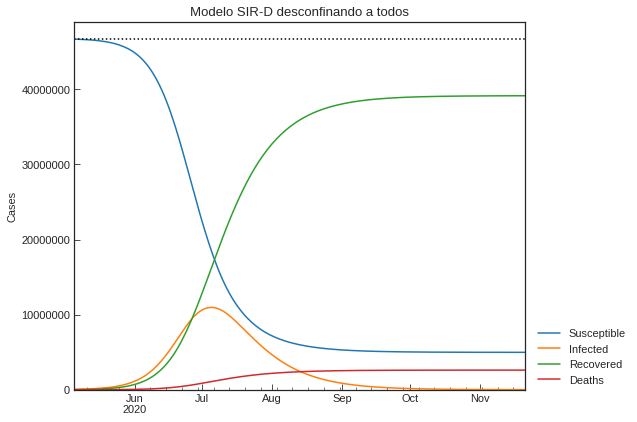

El número total de fallecimientos es de: 2609636
Fallece un 5.58 % de la población


In [12]:
line_plot(
    ori_df.set_index("Date")[["Susceptible", "Infected", "Recovered", "Deaths"]],
    "Modelo SIR-D desconfinando a todos",
    h=poblacion,
    y_integer=True
)
print(u'El número total de fallecimientos es de: {}'.format(ori_df['Deaths'].max()))
print(u'Fallece un {} % de la población'.format(np.round((ori_df['Deaths'].max()/poblacion)*100,2)))

In [13]:
print(u'El número total de fallecimientos es de: {}'.format(ori_df['Deaths'].max()))
print(u'Fallece un {} % de la población'.format(np.round((ori_df['Deaths'].max()/poblacion)*100,2)))

El número total de fallecimientos es de: 2609636
Fallece un 5.58 % de la población


# Escenario ejemplo: Desescalada por edades
___

# Apertura a < 50 años:
___

In [14]:
poblacion_menor_50 = edades.loc[edades['Tasa mortalidad']<=0.5][['Hombres', 'Mujeres']].sum().sum()
poblacion_menor_50

27768675

For example, set $R_0 = 2.5, \kappa=0.005, \rho=0.2$ and initial values $(x_{(0)}, y_{(0)}, z_{(0)}, w_{(0)}) = (0.999, 0.001, 0, 0)$.

In [15]:
r0, kappa, rho = (2.5, 0.0004, 0.2) #(numero reproductivo, tasa mortalidad * tau, tasa efectiva contagio * tau)
sigma = rho / r0 - kappa
initials = (0.999, 0.001, 0, 0) # (susceptibles, infectados, recuperados, fallecidos)
display(Markdown(rf"$\kappa = {kappa},\ \rho = {rho},\ \sigma = {sigma}$."))

$\kappa = 0.0004,\ \rho = 0.2,\ \sigma = 0.0796$.

Suponemos que el día inicial es el 5 de Mayo de 2020. $\tau=1440$ minutos y abrimos al total de la población $N=1,000,000$.

In [16]:
tau = 1440
dia_inicial = datetime.datetime(2020, 5, 5)
poblacion = poblacion_menor_50

In [17]:
%%time
df = simulation(SIRD, initials, step_n=90, kappa=kappa, rho=rho, sigma=sigma)
df.tail()

CPU times: user 4.74 ms, sys: 73 µs, total: 4.82 ms
Wall time: 4.19 ms


,t,x,y,z,w
86,86,0.159565,0.109474,0.727306,0.003655
87,87,0.156190,0.104299,0.735813,0.003698
88,88,0.153043,0.099303,0.743915,0.003738
89,89,0.150106,0.094490,0.751627,0.003777
90,90,0.147365,0.089858,0.758963,0.003814


In [18]:
ori_df = pd.DataFrame(
    {
        "Date": (df["t"] * tau).apply(lambda x: timedelta(minutes=x)) + dia_inicial,
        "Group": "Stopping",
        "País": "España",
        "Province": "-",
        "Susceptible": 0,
        "Confirmed": 0,
        "Infected": (df["y"] * poblacion).astype(np.int64)
    }
)
ori_df["Recovered"] = (df["z"] * poblacion).astype(np.int64)
ori_df["Deaths"] = (df["w"] * poblacion).astype(np.int64)
ori_df["Confirmed"] = ori_df[["Infected", "Recovered", "Deaths"]].sum(axis=1)
ori_df["Susceptible"] = poblacion - ori_df["Confirmed"]
ori_df.tail()

,Date,Group,País,Province,Susceptible,Confirmed,Infected,Recovered,Deaths
86,2020-07-30,Stopping,España,-,4430903,23337772,3039953,20196330,101489
87,2020-07-31,Stopping,España,-,4337201,23431474,2896240,20432558,102676
88,2020-08-01,Stopping,España,-,4249802,23518873,2757522,20657545,103806
89,2020-08-02,Stopping,España,-,4168249,23600426,2623853,20871691,104882
90,2020-08-03,Stopping,España,-,4092124,23676551,2495248,21075397,105906


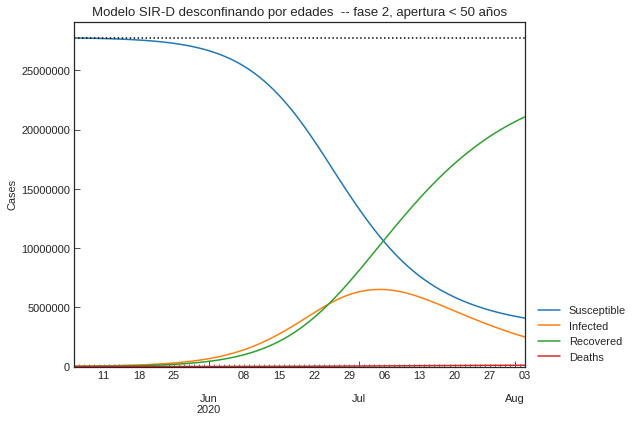

El número total de fallecimientos es de: 105906
Fallece un 0.38 % de la población


In [19]:
line_plot(
    ori_df.set_index("Date")[["Susceptible", "Infected", "Recovered", "Deaths"]],
    "Modelo SIR-D desconfinando por edades  -- fase 2, apertura < 50 años",
    h=poblacion,
    y_integer=True
)
print(u'El número total de fallecimientos es de: {}'.format(ori_df['Deaths'].max()))
print(u'Fallece un {} % de la población'.format(np.round((ori_df['Deaths'].max()/poblacion)*100,2)))

# Apertura a >= 50 y <70 años:
___

In [20]:
poblacion_mayor_50_menor_70 = edades.loc[(edades['Tasa mortalidad']>1) &
                               (edades['Tasa mortalidad']<4)][['Hombres', 'Mujeres']].sum().sum()
poblacion_mayor_50_menor_70

12145105

In [21]:
condicion_inicial = ori_df.loc[ori_df['Date']==ori_df['Date'].max()]
condicion_inicial

,Date,Group,País,Province,Susceptible,Confirmed,Infected,Recovered,Deaths
90,2020-08-03,Stopping,España,-,4092124,23676551,2495248,21075397,105906


In [22]:
susceptibles = poblacion_mayor_50_menor_70 + condicion_inicial['Susceptible'].values[0]
infectados = condicion_inicial['Infected'].values[0]
recuperados = condicion_inicial['Recovered'].values[0]
fallecidos = condicion_inicial['Deaths'].values[0]

In [23]:
ini_sus = susceptibles/(susceptibles+infectados+recuperados+fallecidos)
ini_inf = infectados/(susceptibles+infectados+recuperados+fallecidos)
ini_recup = recuperados/(susceptibles+infectados+recuperados+fallecidos)
ini_fall = fallecidos/(susceptibles+infectados+recuperados+fallecidos)
ini_sus, ini_inf, ini_recup, ini_fall

(0.4068075987791685,
 0.06251595313698677,
 0.5280230787462376,
 0.002653369337607212)

For example, set $R_0 = 2.5, \kappa=0.005, \rho=0.2$ and initial values $(x_{(0)}, y_{(0)}, z_{(0)}, w_{(0)}) = (0.999, 0.001, 0, 0)$.

In [24]:
r0, kappa, rho = (2.5, 0.003, 0.2) #(numero reproductivo, tasa mortalidad * tau, tasa efectiva contagio * tau)
sigma = rho / r0 - kappa
initials = (ini_sus, ini_inf, ini_recup, ini_fall) # (susceptibles, infectados, recuperados, fallecidos)
display(Markdown(rf"$\kappa = {kappa},\ \rho = {rho},\ \sigma = {sigma}$."))

$\kappa = 0.003,\ \rho = 0.2,\ \sigma = 0.077$.

Suponemos que el día inicial es el 5 de Mayo de 2020. $\tau=1440$ minutos y abrimos al total de la población $N=1,000,000$.

In [25]:
tau = 1440
dia_inicial = datetime.datetime(2020, 8, 3)
poblacion = susceptibles + infectados + recuperados + fallecidos

In [26]:
%%time
df = simulation(SIRD, initials, step_n=90, kappa=kappa, rho=rho, sigma=sigma)
df.tail()

CPU times: user 3.32 ms, sys: 0 ns, total: 3.32 ms
Wall time: 3.12 ms


,t,x,y,z,w
86,86,0.225987,0.008051,0.754485,0.011477
87,87,0.225632,0.007775,0.755092,0.011500
88,88,0.225290,0.007509,0.755679,0.011523
89,89,0.224959,0.007251,0.756245,0.011545
90,90,0.224639,0.007001,0.756794,0.011567


In [27]:
ori_df = pd.DataFrame(
    {
        "Date": (df["t"] * tau).apply(lambda x: timedelta(minutes=x)) + dia_inicial,
        "Group": "Stopping",
        "País": "España",
        "Province": "-",
        "Susceptible": 0,
        "Confirmed": 0,
        "Infected": (df["y"] * poblacion).astype(np.int64)
    }
)
ori_df["Recovered"] = (df["z"] * poblacion).astype(np.int64)
ori_df["Deaths"] = (df["w"] * poblacion).astype(np.int64)
ori_df["Confirmed"] = ori_df[["Infected", "Recovered", "Deaths"]].sum(axis=1)
ori_df["Susceptible"] = poblacion - ori_df["Confirmed"]
ori_df.tail()

,Date,Group,País,Province,Susceptible,Confirmed,Infected,Recovered,Deaths
86,2020-10-28,Stopping,España,-,9020007,30893773,321344,30114356,458073
87,2020-10-29,Stopping,España,-,9005841,30907939,310344,30138579,459016
88,2020-10-30,Stopping,España,-,8992164,30921616,299701,30161987,459928
89,2020-10-31,Stopping,España,-,8978954,30934826,289403,30184613,460810
90,2020-11-01,Stopping,España,-,8966184,30947596,279440,30206493,461663


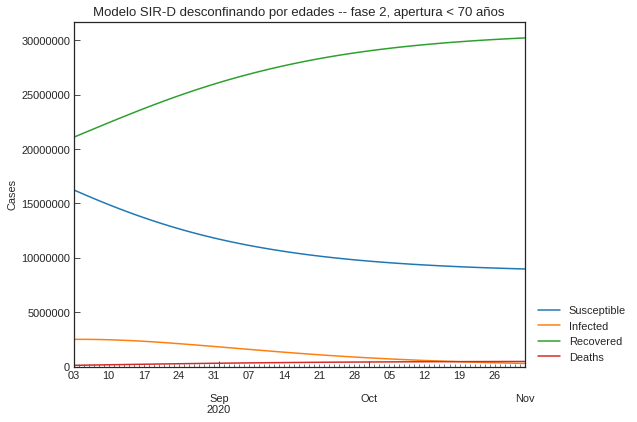

El número total de fallecimientos es de: 461663
Fallece un 1.16 % de la población


In [28]:
line_plot(
    ori_df.set_index("Date")[["Susceptible", "Infected", "Recovered", "Deaths"]],
    "Modelo SIR-D desconfinando por edades -- fase 2, apertura < 70 años",
    h=poblacion,
    y_integer=True
)
print(u'El número total de fallecimientos es de: {}'.format(ori_df['Deaths'].max()))
print(u'Fallece un {} % de la población'.format(np.round((ori_df['Deaths'].max()/poblacion)*100,2)))

# Apertura a >= 70:
___

In [29]:
poblacion_mayor_70 = edades.loc[(edades['Tasa mortalidad']>4)][['Hombres', 'Mujeres']].sum().sum()
poblacion_mayor_70

6823002

In [30]:
condicion_inicial = ori_df.loc[ori_df['Date']==ori_df['Date'].max()]
condicion_inicial

,Date,Group,País,Province,Susceptible,Confirmed,Infected,Recovered,Deaths
90,2020-11-01,Stopping,España,-,8966184,30947596,279440,30206493,461663


In [31]:
susceptibles = poblacion_mayor_70 + condicion_inicial['Susceptible'].values[0]
infectados = condicion_inicial['Infected'].values[0]
recuperados = condicion_inicial['Recovered'].values[0]
fallecidos = condicion_inicial['Deaths'].values[0]

In [32]:
ini_sus = susceptibles/(susceptibles+infectados+recuperados+fallecidos)
ini_inf = infectados/(susceptibles+infectados+recuperados+fallecidos)
ini_recup = recuperados/(susceptibles+infectados+recuperados+fallecidos)
ini_fall = fallecidos/(susceptibles+infectados+recuperados+fallecidos)
ini_sus, ini_inf, ini_recup, ini_fall

(0.3378321168967089,
 0.005979016698239943,
 0.6463109291521183,
 0.009877937252932819)

For example, set $R_0 = 2.5, \kappa=0.005, \rho=0.2$ and initial values $(x_{(0)}, y_{(0)}, z_{(0)}, w_{(0)}) = (0.999, 0.001, 0, 0)$.

In [33]:
r0, kappa, rho = (2.5, 0.005, 0.2) #(numero reproductivo, tasa mortalidad * tau, tasa efectiva contagio * tau)
sigma = rho / r0 - kappa
initials = (ini_sus, ini_inf, ini_recup, ini_fall) # (susceptibles, infectados, recuperados, fallecidos)
display(Markdown(rf"$\kappa = {kappa},\ \rho = {rho},\ \sigma = {sigma}$."))

$\kappa = 0.005,\ \rho = 0.2,\ \sigma = 0.075$.

Suponemos que el día inicial es el 5 de Mayo de 2020. $\tau=1440$ minutos y abrimos al total de la población $N=1,000,000$.

In [34]:
tau = 1440
dia_inicial = datetime.datetime(2020, 11, 1)
poblacion = susceptibles + infectados + recuperados + fallecidos

In [35]:
%%time
df = simulation(SIRD, initials, step_n=20, kappa=kappa, rho=rho, sigma=sigma)
df.tail()

CPU times: user 3.49 ms, sys: 0 ns, total: 3.49 ms
Wall time: 3.16 ms


,t,x,y,z,w
16,16,0.332039,0.004854,0.652797,0.010310
17,17,0.331719,0.004788,0.653159,0.010334
18,18,0.331404,0.004723,0.653515,0.010358
19,19,0.331093,0.004658,0.653867,0.010382
20,20,0.330787,0.004594,0.654214,0.010405


In [36]:
ori_df = pd.DataFrame(
    {
        "Date": (df["t"] * tau).apply(lambda x: timedelta(minutes=x)) + dia_inicial,
        "Group": "Stopping",
        "País": "España",
        "Province": "-",
        "Susceptible": 0,
        "Confirmed": 0,
        "Infected": (df["y"] * poblacion).astype(np.int64)
    }
)
ori_df["Recovered"] = (df["z"] * poblacion).astype(np.int64)
ori_df["Deaths"] = (df["w"] * poblacion).astype(np.int64)
ori_df["Confirmed"] = ori_df[["Infected", "Recovered", "Deaths"]].sum(axis=1)
ori_df["Susceptible"] = poblacion - ori_df["Confirmed"]
ori_df.tail()

,Date,Group,País,Province,Susceptible,Confirmed,Infected,Recovered,Deaths
16,2020-11-17,Stopping,España,-,15518442,31218340,226837,30509631,481872
17,2020-11-18,Stopping,España,-,15503489,31233293,223767,30526528,482998
18,2020-11-19,Stopping,España,-,15488752,31248030,220725,30543196,484109
19,2020-11-20,Stopping,España,-,15474229,31262553,217711,30559637,485205
20,2020-11-21,Stopping,España,-,15459916,31276866,214725,30575854,486287


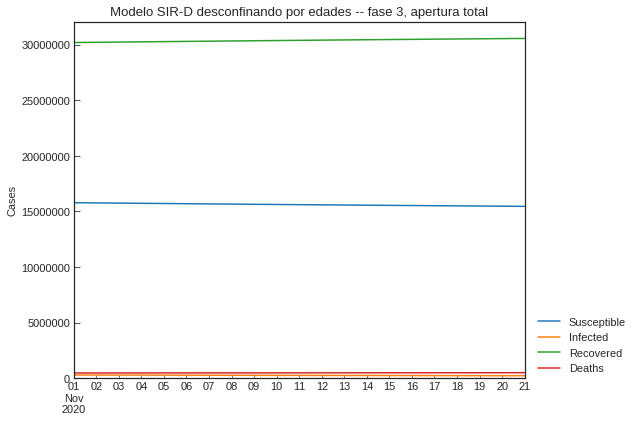

El número total de fallecimientos es de: 486287
Fallece un 1.04 % de la población


In [37]:
line_plot(
    ori_df.set_index("Date")[["Susceptible", "Infected", "Recovered", "Deaths"]],
    "Modelo SIR-D desconfinando por edades -- fase 3, apertura total",
    h=poblacion,
    y_integer=True
)
print(u'El número total de fallecimientos es de: {}'.format(ori_df['Deaths'].max()))
print(u'Fallece un {} % de la población'.format(np.round((ori_df['Deaths'].max()/poblacion)*100,2)))